In [ ]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model,load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, load_datasets_and_node_features, pre_data_deal
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random

seed = 42  # 可以是任意数字，使用相同的数字确保每次运行的初始化相同
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # 对所有GPU设置种子

def plotting(y, x_name, y_name, random_states):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(y) + 1), y, label=y_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(f'{random_states}_{y_name} Over Time')
    plt.legend()
    plt.show()

# 初始化参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'
cell_type = "NHEK"
input_dir = f'{base_dir}/{cell_type}'
output_dir = f'{input_dir}/random_state_split_dataset_CNN_GAT'
non_gene_ids_file = '/home/tjzhang03/zxj/deal_data/data_input/BENGI/non_gene_ids.txt'
geometric_batch_size = 1
node_height = 7 #行
node_width =21 #列
cnn_out_channels = 64  #节点通过CNN后的特征维度
gat1_out_channels = 32  #第一层GAT输出维度
gat2_out_channels = 16  #第二层GAT输出节点维度
Edge_hidden_dim = 16
num_heads=6
lr=0.0005
weight_decay=1e-4
step_size=30
gamma=0.1
num_epochs = 100
threshold = 0.5

# 循环不同的 random_state 值
random_states = range(30)  # 示例：遍历5个不同的random_state
# random_states = [8] # 示例：遍历5个不同的random_state

aucs_per_state = []
# standardized_df, enhancer_features, promoter_features = pre_data_deal(input_dir, cell_type, non_gene_ids_file)
for random_state in random_states:  
    # print(random_state)
    #过滤、平衡、划分训练集验证测试、转换数据格式
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = balance_and_split_by_random_state(standardized_df, enhancer_features, promoter_features, random_state, output_dir)
    train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(output_dir, random_state)
    train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
    val_loader = load_subgraph_loader(val_nodes_dict, val_edges_df, geometric_batch_size, is_training=False) #val_loader是字典

    model = DualCNNandGATv2(node_height, node_width, cnn_out_channels, gat1_out_channels, gat2_out_channels, Edge_hidden_dim, 2, num_heads).to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # criterion = torch.nn.BCELoss()
    # criterion = torch.nn.BCEWithLogitsLoss()
    criterion = CombinedLoss(weight_bce=0.6)
    
    # 保存每个 epoch 的
    best_val_auc = float('inf')
    last_train_loss = float('inf')
    last_val_loss = float('inf')

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        # 训练和验证模型的代码
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
        train_losses.append(train_loss)
        val_loss, val_auc, _, _ = evaluate_model(model, val_loader, criterion, threshold, device)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        scheduler.step()  # 更新学习率

    # 选取此 random_state 下的最佳 AUC
    best_val_auc = max(val_aucs)
    aucs_per_state.append(best_val_auc)
    # 计算当前 random_state 下所有epoch的AUC值的方差
    current_state_auc_variance = np.var(val_aucs)
    print(f"Current random state {random_state}, MAX AUC:{best_val_auc}, AUC variance: {current_state_auc_variance}")

    plotting(train_losses, 'epoch', 'train_loss', random_state)
    plotting(val_losses, 'epoch', 'val_loss', random_state)
    plotting(val_aucs, 'epoch', 'val_auc', random_state)
    

    # # 循环结束，不再需要模型和数据时
    del model  # 删除模型实例
    del train_loader, val_loader  # 删除数据变量
    gc.collect()  # 显式调用垃圾收集器
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # 清理CUDA缓存

    
    

    

In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model,load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, load_datasets_and_node_features, pre_data_deal, create_data
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random
import os

seed = 42  # 可以是任意数字，使用相同的数字确保每次运行的初始化相同
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # 对所有GPU设置种子

def plotting(y, x_name, y_name, random_states):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(y) + 1), y, label=y_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(f'{random_states}_{y_name} Over Time')
    plt.legend()
    plt.show()

# 初始化参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'
cell_type = ['NHEK', 'IMR90', 'HMEC']  # or ['K562'] for a single cell line
# input_dir = f'{base_dir}/{cell_type}'
# output_dir = f'{input_dir}/random_state_split_dataset_CNN_GAT02'
model_out_dir = f'/home/tjzhang03/zxj/deal_data/result/normal'
save_output_dir = '/home/tjzhang03/zxj/deal_data/data_output/normal/random_state_split_dataset_CNN_GAT02'



geometric_batch_size = 1  #一个batch里面只有一个染色体子图
node_height, node_width = 7, 21  #节点特征的位点，七种特征，21个窗口

out_channels = 32 
kernel_size = 3
cnn_out_channels = 64  #节点通过CNN后的特征维度 64
gat1_out_channels = 32  #第一层GAT输出维度
gat2_out_channels = 16  #第二层GAT输出节点维度
Edge_hidden_dim = 16
num_heads=6
lr=0.0001
weight_decay=1e-4
step_size=30
gamma=0.8
num_epochs = 100
threshold = 0.5

# cnn_out_channels = [64,128]  #节点通过CNN后的特征维度
# gat1_out_channels = [32,64,128]  #第一层GAT输出维度
# gat2_out_channels = [8,16,32,64]  #第二层GAT输出节点维度
# Edge_hidden_dim = [8,16,32]
# num_heads=[2,8]
# lr=[0.001,0.0001]
# weight_decay=[1e-4,1e-5]
# step_size=[10,20,30]
# gamma=[0.1,0.5]
# num_epochs = [50]
# threshold = 0.5

# 循环不同的 random_state 值
# random_states = range(30)  # 示例：遍历5个不同的random_state
random_states = [27] # 示例：遍历5个不同的random_state

aucs_per_state = []
for random_state in random_states:  
    model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')
    # print(random_state)
    #过滤、平衡、划分训练集验证测试、转换数据格式
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = create_data(input_dir, cell_type, random_state)
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state)
    train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state, save_output_dir)

    #转换封装成模型需要的输入格式
    train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
    val_loader = load_subgraph_loader(val_nodes_dict, val_edges_df, geometric_batch_size, is_training=False) #val_loader是字典
    test_loader = load_subgraph_loader(test_nodes_dict, test_edges_df, geometric_batch_size, is_training=False)

    #定义模型、优化器等
    model = DualCNNandGATv2(node_height, node_width, cnn_out_channels, gat1_out_channels, gat2_out_channels, Edge_hidden_dim, 2, num_heads).to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # criterion = torch.nn.BCELoss()
    # criterion = torch.nn.BCEWithLogitsLoss()
    criterion = CombinedLoss(weight_bce=0.6)
    
    # 保存每个 epoch 的
    best_val_auc = float('-inf')
    last_train_loss = float('inf')
    last_val_loss = float('inf')
    best_model = None

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        # 训练和验证模型的代码
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
        train_losses.append(train_loss)
        val_loss, val_auc, _, _ = evaluate_model(model, val_loader, criterion, threshold, device)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        scheduler.step()  # 更新学习率

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model.state_dict()  # Save the model state

    #保存AUC最高那个模型模型
    # model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')
    torch.save(best_model, model_save_path)
    print(f"Model saved for random state {random_state} with AUC: {best_val_auc}")

    # Load best model for testing 测试
    model.load_state_dict(best_model)
    test_loss, test_auc, _, _ = evaluate_model(model, test_loader, criterion, threshold, device)
    print(f"Testing results for random state {random_state}: AUC = {test_auc}")

    # 选取此 random_state 下的最佳 AUC
    # best_val_auc = max(val_aucs)
    # aucs_per_state.append(best_val_auc)
    # # 计算当前 random_state 下所有epoch的AUC值的方差
    # current_state_auc_variance = np.var(val_aucs)
    # print(f"Current random state {random_state}, MAX AUC:{best_val_auc}, AUC variance: {current_state_auc_variance}")

    # plotting(train_losses, 'epoch', 'train_loss', random_state)
    # plotting(val_losses, 'epoch', 'val_loss', random_state)
    # plotting(val_aucs, 'epoch', 'val_auc', random_state)
    

    # # 循环结束，不再需要模型和数据时
    del model  # 删除模型实例
    del train_loader, val_loader, test_loader # 删除数据变量
    gc.collect()  # 显式调用垃圾收集器
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # 清理CUDA缓存

/home/tjzhang03/anaconda3/envs/PYG/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: __init__() missing 1 required positional argument: 'edge_in_channels'

In [21]:
'''HMEC、'NHEK', 'IMR90'分别最优超参'''
import optuna
import json 
import pandas as pd
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model,load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, load_datasets_and_node_features, pre_data_deal, create_data
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random
import os
# 初始化参数
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'
# cell_type = ['NHEK', 'IMR90', 'HMEC']  # or ['K562'] for a single cell line
cell_type = ['IMR90']
save_output_dir = '/home/tjzhang03/zxj/deal_data/data_output/IMR90/random_state_split_dataset_CNN_GAT02'



geometric_batch_size = 1  #一个batch里面只有一个染色体子图
node_height, node_width = 7, 21  #节点特征的位点，七种特征，21个窗口
num_epochs = 50
threshold = 0.6
# kernel_size = 3

random_state = 22 # 示例：遍历5个不同的random_state(IMR90IMR90(22,0.7)、NHEK(24,0.6)、HMEC(21,0.5))

def objective(trial):
    # 定义超参数空间
    out_channels = trial.suggest_int('out_channels', 32, 128) 
    kernel_size = trial.suggest_int('kernel_size', 3, 7) 
    cnn_out_channels = trial.suggest_int('cnn_out_channels', 32, 128)
    gat1_out_channels = trial.suggest_int('gat1_out_channels', 16, 128)
    gat2_out_channels = trial.suggest_int('gat2_out_channels', 8, 64)
    edge_hidden_dim = trial.suggest_int('edge_hidden_dim', 8, 32)
    num_heads = trial.suggest_int('num_heads', 1, 8)
    lr = trial.suggest_float('lr', 0.0001, 0.01, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    step_size = trial.suggest_int('step_size', 10, 30)
    gamma = trial.suggest_float('gamma', 0.1, 0.9)

    # 加载数据集
    train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state, save_output_dir)

    #转换封装成模型需要的输入格式
    train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
    val_loader = load_subgraph_loader(val_nodes_dict, val_edges_df, geometric_batch_size, is_training=False) #val_loader是字典

    #定义模型、优化器等
    model = DualCNNandGATv2(node_height, node_width, out_channels, kernel_size, cnn_out_channels, gat1_out_channels, 
                            gat2_out_channels, edge_hidden_dim, 2, num_heads).to(device)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = CombinedLoss(weight_bce=0.6)
    
    # 保存每个 epoch 的
    best_val_auc = float('-inf')

   

    for epoch in range(num_epochs):
        # 训练和验证模型的代码
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
        val_loss, val_auc, _, _ = evaluate_model(model, val_loader, criterion, threshold, device)
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
        scheduler.step()  # 更新学习率


    # print(f"Model saved for random state {random_state} with AUC: {best_val_auc}")

    return best_val_auc  # 返回评估指标，例如AUC


# 创建研究并执行优化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

# Save the best hyperparameters
best_hyperparams = study.best_trial.params
best_hyperparams_path = '/home/tjzhang03/zxj/deal_data/finally_scr/IMR90_best_hyperparameters.json'
with open(best_hyperparams_path, 'w') as f:
    json.dump(best_hyperparams, f)

print("Best hyperparameters saved to:", best_hyperparams_path)

[I 2024-10-19 12:30:54,145] A new study created in memory with name: no-name-902116f8-f2d1-4a9f-95ac-cbec332c8c41
[I 2024-10-19 12:31:10,800] Trial 0 finished with value: 0.8009040786818564 and parameters: {'out_channels': 120, 'kernel_size': 6, 'cnn_out_channels': 69, 'gat1_out_channels': 33, 'gat2_out_channels': 23, 'edge_hidden_dim': 10, 'num_heads': 4, 'lr': 0.00021778515538313682, 'weight_decay': 0.0003897662649187991, 'step_size': 25, 'gamma': 0.13435163266183886}. Best is trial 0 with value: 0.8009040786818564.
[I 2024-10-19 12:31:25,797] Trial 1 finished with value: 0.7697618253173808 and parameters: {'out_channels': 34, 'kernel_size': 3, 'cnn_out_channels': 120, 'gat1_out_channels': 54, 'gat2_out_channels': 26, 'edge_hidden_dim': 30, 'num_heads': 5, 'lr': 0.00012114288696445715, 'weight_decay': 0.00014954886471697576, 'step_size': 16, 'gamma': 0.7275982675950935}. Best is trial 0 with value: 0.8009040786818564.
[I 2024-10-19 12:31:39,085] Trial 2 finished with value: 0.7845226

Best trial:
Value: 0.820646042868265
Params: 
out_channels: 119
kernel_size: 7
cnn_out_channels: 113
gat1_out_channels: 59
gat2_out_channels: 16
edge_hidden_dim: 26
num_heads: 2
lr: 0.0008425800179420112
weight_decay: 0.0005116689397321729
step_size: 14
gamma: 0.11507501122813821
Best hyperparameters saved to: /home/tjzhang03/zxj/deal_data/finally_scr/IMR90_best_hyperparameters.json


In [23]:
'''HMEC、'NHEK', 'IMR90'分别训练测试'''
import json

import pandas as pd
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model,load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, load_datasets_and_node_features, pre_data_deal, create_data, final_load_datas
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random
import os
import time

seed = 42  # 可以是任意数字，使用相同的数字确保每次运行的初始化相同
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # 对所有GPU设置种子


# 初始化参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'
# cell_type = ['NHEK', 'IMR90', 'HMEC']  # or ['K562'] for a single cell line
# model_out_dir = f'/home/tjzhang03/zxj/deal_data/result/normal'
# save_output_dir = '/home/tjzhang03/zxj/deal_data/data_output/normal/random_state_split_dataset_CNN_GAT02'
cell_type = ['IMR90']
save_output_dir = '/home/tjzhang03/zxj/deal_data/data_output/IMR90/random_state_split_dataset_CNN_GAT02'
model_out_dir = f'/home/tjzhang03/zxj/deal_data/result/IMR90'


geometric_batch_size = 1  #一个batch里面只有一个染色体子图
node_height, node_width = 7, 21  #节点特征的位点，七种特征，21个窗口

# 加载JSON文件
# 定义文件路径
file_path = f'/home/tjzhang03/zxj/deal_data/finally_scr/IMR90_best_hyperparameters.json'
with open(file_path, 'r') as json_file:
    loaded_params = json.load(json_file)

# 解包超参数
out_channels=loaded_params['out_channels']
kernel_size=loaded_params['kernel_size']
cnn_out_channels=loaded_params['cnn_out_channels']
gat1_out_channels=loaded_params['gat1_out_channels']
gat2_out_channels=loaded_params['gat2_out_channels']
edge_hidden_dim=loaded_params['edge_hidden_dim']
num_heads=loaded_params['num_heads']
lr = loaded_params['lr']
weight_decay = loaded_params['weight_decay']
step_size = loaded_params['step_size']
gamma = loaded_params['gamma']



num_epochs = 200
threshold = 0.7  #NHEK0.6 24

# random_states = range(30)  # 示例：遍历5个不同的random_state
random_states = [22] # 示例：遍历5个不同的random_state

aucs_per_state = []
for random_state in random_states:  
    model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')
    # print(random_state)
    #过滤、平衡、划分训练集验证测试、转换数据格式
    train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state, save_output_dir)

    #转换封装成模型需要的输入格式
    train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
    val_loader = load_subgraph_loader(val_nodes_dict, val_edges_df, geometric_batch_size, is_training=False) #val_loader是字典
    test_loader = load_subgraph_loader(test_nodes_dict, test_edges_df, geometric_batch_size, is_training=False)

    start_time = time.time()  # 记录训练开始时间
    #定义模型、优化器等
    model = DualCNNandGATv2(node_height, node_width, out_channels, kernel_size, cnn_out_channels, gat1_out_channels, 
                            gat2_out_channels, edge_hidden_dim, 2, num_heads).to(device)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = CombinedLoss(weight_bce=0.6)
    
    # 保存每个 epoch 的
    best_val_auc = float('-inf')
    last_train_loss = float('inf')
    last_val_loss = float('inf')
    best_model = None

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        # 训练和验证模型的代码
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
        train_losses.append(train_loss)
        val_loss, val_auc, _, _ = evaluate_model(model, val_loader, criterion, threshold, device)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        scheduler.step()  # 更新学习率

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model.state_dict()  # Save the model state

    # 训练循环结束后
    total_training_time = time.time() - start_time
    print("Total training time: {:.2f} seconds".format(total_training_time))
    #保存AUC最高那个模型模型
    # model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')
    torch.save(best_model, model_save_path)
    print(f"Model saved for random state {random_state} with AUC: {best_val_auc}")

    # Load best model for testing 测试
    model.load_state_dict(best_model)
    test_loss, test_auc, test_aupr, test_acc = evaluate_model(model, test_loader, criterion, threshold, device)
    print(f"Final test AUC for random state {random_state} test_auc:{test_auc}, test_aupr:{test_aupr}, test_acc:{test_acc}")


    # # 循环结束，不再需要模型和数据时
    del model  # 删除模型实例
    del train_loader, val_loader, test_loader # 删除数据变量
    gc.collect()  # 显式调用垃圾收集器
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # 清理CUDA缓存

Total training time: 56.98 seconds
Model saved for random state 22 with AUC: 0.7976071309404643
Final test AUC for random state 22 test_auc:0.7652459352720932, test_aupr:0.745420954692433, test_acc:0.4936708860759494


In [4]:
'''NHEK'''
import pandas as pd
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model,load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, load_datasets_and_node_features, pre_data_deal, create_data
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random
import os
import time


seed = 42  # 可以是任意数字，使用相同的数字确保每次运行的初始化相同
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # 对所有GPU设置种子


# 初始化参数
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'

cell_type = ['NHEK']
save_output_dir = '/home/tjzhang03/zxj/deal_data/data_output/NHEK/random_state_split_dataset_CNN_GAT02'
model_out_dir = f'/home/tjzhang03/zxj/deal_data/result/NHEK'

geometric_batch_size = 1  #一个batch里面只有一个染色体子图
node_height, node_width = 7, 21  #节点特征的位点，七种特征，21个窗口


# 循环不同的 random_state 值
# random_states = range(30)  # 示例：遍历5个不同的random_state
random_states = [24] # 示例：遍历5个不同的random_state

aucs_per_state = []
for random_state in random_states:  
    model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')
    # print(random_state)
    #过滤、平衡、划分训练集验证测试、转换数据格式
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = create_data(input_dir, cell_type, random_state)
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state)
    train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state, save_output_dir)

    #转换封装成模型需要的输入格式
    train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
    val_loader = load_subgraph_loader(val_nodes_dict, val_edges_df, geometric_batch_size, is_training=False) #val_loader是字典
    test_loader = load_subgraph_loader(test_nodes_dict, test_edges_df, geometric_batch_size, is_training=False)

    start_time = time.time()  # 记录训练开始时间
    #定义模型、优化器等
    model = DualCNNandGATv2(node_height, node_width, out_channels, kernel_size, cnn_out_channels, gat1_out_channels, 
                            gat2_out_channels, Edge_hidden_dim, 2, num_heads).to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # criterion = torch.nn.BCELoss()
    # criterion = torch.nn.BCEWithLogitsLoss()
    criterion = CombinedLoss(weight_bce=0.6)
    
    # 保存每个 epoch 的
    best_val_auc = float('-inf')
    last_train_loss = float('inf')
    last_val_loss = float('inf')
    best_model = None

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        # 训练和验证模型的代码
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
        train_losses.append(train_loss)
        val_loss, val_auc, _, _ = evaluate_model(model, val_loader, criterion, threshold, device)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        scheduler.step()  # 更新学习率

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model.state_dict()  # Save the model state

    # 训练循环结束后
    total_training_time = time.time() - start_time
    print("Total training time: {:.2f} seconds".format(total_training_time))
    
    #保存AUC最高那个模型模型
    # model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')
    torch.save(best_model, model_save_path)
    print(f"Model saved for random state {random_state} with AUC: {best_val_auc}")

    # Load best model for testing 测试
    model.load_state_dict(best_model)
    test_loss, test_auc, test_aupr, test_acc = evaluate_model(model, test_loader, criterion, threshold, device)
    print(f"Final test AUC for random state {random_state} test_auc:{test_auc}, test_aupr:{test_aupr}, test_acc:{test_acc}")
    

    # # 循环结束，不再需要模型和数据时
    del model  # 删除模型实例
    del train_loader, val_loader, test_loader # 删除数据变量
    gc.collect()  # 显式调用垃圾收集器
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # 清理CUDA缓存

Total training time: 24.76 seconds
Model saved for random state 24 with AUC: 0.6942581612064446
Final test AUC for random state 24 test_auc:0.7154941366076915, test_aupr:0.7128048364939361, test_acc:0.4862043251304996


In [ ]:
import torch

# 假设你的模型类为 DualCNNandGATv2，并且已经有了模型的路径
model_path = 'path/to/your/model.pt'
model = torch.load(model_path)

# 创建一个假数据输入，假设输入的形状符合模型要求
# 这里需要根据模型的输入格式调整，比如节点特征的维度
batch_size = 32
node_height = 7
node_width = 21
edge_index = torch.randint(0, batch_size, (2, 100))  # 示例边索引
edge_attr = torch.randn(100, 3)  # 示例边特征

# 创建一个伪造的 batch_data 对象
class BatchData:
    def __init__(self, x_e, x_p, edge_index, edge_attr, node_degree):
        self.x_e = x_e
        self.x_p = x_p
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.node_degree = node_degree

# 随机生成特征数据
x_e = torch.randn(batch_size, node_height, node_width)
x_p = torch.randn(batch_size, node_height, node_width)
node_degree = torch.randint(0, 10, (batch_size * 2,))  # 假设的节点度

batch_data = BatchData(x_e, x_p, edge_index, edge_attr, node_degree)

# 定义一个hook函数来捕获每一层的输出
def get_shapes(model, batch_data):
    shapes = []
    def hook(module, input, output):
        shapes.append(output.shape)

    # 注册hook
    for layer in model.children():
        layer.register_forward_hook(hook)

    # 前向传播
    with torch.no_grad():
        model(batch_data)

    return shapes

# 获取模型各层的输出维度
shapes = get_shapes(model, batch_data)

# 打印每一层的维度
for i, shape in enumerate(shapes):
    print(f"Layer {i + 1}: {shape}")


In [1]:
'''K562'''
import pandas as pd
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model,load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, load_datasets_and_node_features, pre_data_deal, create_data
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random
import os
import time


seed = 42  # 可以是任意数字，使用相同的数字确保每次运行的初始化相同
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # 对所有GPU设置种子


# 初始化参数
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'

cell_type = ['K562']
save_output_dir = '/home/tjzhang03/zxj/deal_data/data_output/K562/random_state_split_dataset_CNN_GAT02'
model_out_dir = f'/home/tjzhang03/zxj/deal_data/result/K562'

geometric_batch_size = 1  #一个batch里面只有一个染色体子图
node_height, node_width = 7, 21  #节点特征的位点，七种特征，21个窗口

out_channels = 32 
kernel_size = 3
cnn_out_channels = 64  #节点通过CNN后的特征维度 64
gat1_out_channels = 32  #第一层GAT输出维度
gat2_out_channels = 16  #第二层GAT输出节点维度
Edge_hidden_dim = 16
num_heads=6
lr=0.0001
weight_decay=1e-4
step_size=30
gamma=0.8
num_epochs = 200
threshold = 0.5

# cnn_out_channels = [64,128]  #节点通过CNN后的特征维度
# gat1_out_channels = [32,64,128]  #第一层GAT输出维度
# gat2_out_channels = [8,16,32,64]  #第二层GAT输出节点维度
# Edge_hidden_dim = [8,16,32]
# num_heads=[2,8]
# lr=[0.001,0.0001]
# weight_decay=[1e-4,1e-5]
# step_size=[10,20,30]
# gamma=[0.1,0.5]
# num_epochs = [50]
# threshold = 0.5

# 循环不同的 random_state 值
# random_states = range(30)  # 示例：遍历5个不同的random_state
random_states = [21] # 示例：遍历5个不同的random_state

aucs_per_state = []
for random_state in random_states:  
    model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')
    # print(random_state)
    #过滤、平衡、划分训练集验证测试、转换数据格式
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = create_data(input_dir, cell_type, random_state)
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state)
    train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state, save_output_dir)

    #转换封装成模型需要的输入格式
    train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
    val_loader = load_subgraph_loader(val_nodes_dict, val_edges_df, geometric_batch_size, is_training=False) #val_loader是字典
    test_loader = load_subgraph_loader(test_nodes_dict, test_edges_df, geometric_batch_size, is_training=False)

    start_time = time.time()  # 记录训练开始时间
    #定义模型、优化器等
    model = DualCNNandGATv2(node_height, node_width, out_channels, kernel_size, cnn_out_channels, gat1_out_channels, 
                            gat2_out_channels, Edge_hidden_dim, 2, num_heads).to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # criterion = torch.nn.BCELoss()
    # criterion = torch.nn.BCEWithLogitsLoss()
    criterion = CombinedLoss(weight_bce=0.6)
    
    # 保存每个 epoch 的
    best_val_auc = float('-inf')
    last_train_loss = float('inf')
    last_val_loss = float('inf')
    best_model = None

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        # 训练和验证模型的代码
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
        train_losses.append(train_loss)
        val_loss, val_auc, _, _ = evaluate_model(model, val_loader, criterion, threshold, device)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        scheduler.step()  # 更新学习率

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model.state_dict()  # Save the model state

    # 训练循环结束后
    total_training_time = time.time() - start_time
    print("Total training time: {:.2f} seconds".format(total_training_time))
    
    #保存AUC最高那个模型模型
    # model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')
    torch.save(best_model, model_save_path)
    print(f"Model saved for random state {random_state} with AUC: {best_val_auc}")

    # Load best model for testing 测试
    model.load_state_dict(best_model)
    test_loss, test_auc, test_aupr, test_acc = evaluate_model(model, test_loader, criterion, threshold, device)
    print(f"Final test AUC for random state {random_state} test_auc:{test_auc}, test_aupr:{test_aupr}, test_acc:{test_acc}")
    

    # # 循环结束，不再需要模型和数据时
    del model  # 删除模型实例
    del train_loader, val_loader, test_loader # 删除数据变量
    gc.collect()  # 显式调用垃圾收集器
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # 清理CUDA缓存

/home/tjzhang03/anaconda3/envs/PYG/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total training time: 60.32 seconds
Model saved for random state 21 with AUC: 0.6874705507358851
Final test AUC for random state 21 test_auc:0.6547252194799513, test_aupr:0.597677565450281, test_acc:0.4811218985976268


In [1]:
'''最优超参'''
import optuna

import pandas as pd
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model,load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, load_datasets_and_node_features, pre_data_deal, create_data
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random
import os

# seed = 42  # 可以是任意数字，使用相同的数字确保每次运行的初始化相同
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)  # 对所有GPU设置种子


# 初始化参数
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'
# cell_type = ['NHEK', 'IMR90', 'HMEC']  # or ['K562'] for a single cell line
cell_type = ['K562']
model_out_dir = f'/home/tjzhang03/zxj/deal_data/result/K562'
save_output_dir = '/home/tjzhang03/zxj/deal_data/data_output/K562/random_state_split_dataset_CNN_GAT02'



geometric_batch_size = 1  #一个batch里面只有一个染色体子图
node_height, node_width = 7, 21  #节点特征的位点，七种特征，21个窗口
num_epochs = 100
threshold = 0.5
# kernel_size = 3

random_state = 21 # 示例：遍历5个不同的random_state

def objective(trial):
    # 定义超参数空间
    out_channels = trial.suggest_int('out_channels', 32, 128) 
    kernel_size = trial.suggest_int('kernel_size', 3, 7) 
    cnn_out_channels = trial.suggest_int('cnn_out_channels', 32, 128)
    gat1_out_channels = trial.suggest_int('gat1_out_channels', 16, 128)
    gat2_out_channels = trial.suggest_int('gat2_out_channels', 8, 64)
    edge_hidden_dim = trial.suggest_int('edge_hidden_dim', 8, 32)
    num_heads = trial.suggest_int('num_heads', 1, 8)
    lr = trial.suggest_float('lr', 0.0001, 0.01, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    step_size = trial.suggest_int('step_size', 10, 30)
    gamma = trial.suggest_float('gamma', 0.1, 0.9)

    # 加载数据集
    train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state, save_output_dir)

    #转换封装成模型需要的输入格式
    train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
    val_loader = load_subgraph_loader(val_nodes_dict, val_edges_df, geometric_batch_size, is_training=False) #val_loader是字典

    #定义模型、优化器等
    model = DualCNNandGATv2(node_height, node_width, out_channels, kernel_size, cnn_out_channels, gat1_out_channels, 
                            gat2_out_channels, edge_hidden_dim, 2, num_heads).to(device)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = CombinedLoss(weight_bce=0.6)
    
    # 保存每个 epoch 的
    best_val_auc = float('-inf')

   

    for epoch in range(num_epochs):
        # 训练和验证模型的代码
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
        val_loss, val_auc, _, _ = evaluate_model(model, val_loader, criterion, threshold, device)
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
        scheduler.step()  # 更新学习率


    # print(f"Model saved for random state {random_state} with AUC: {best_val_auc}")

    return best_val_auc  # 返回评估指标，例如AUC


# 创建研究并执行优化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")
    

/home/tjzhang03/anaconda3/envs/PYG/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-09-20 18:38:02,315] A new study created in memory with name: no-name-2520856a-de92-45e8-9121-d731b956061f
[I 2024-09-20 18:38:32,110] Trial 0 finished with value: 0.7198439535463843 and parameters: {'out_channels': 117, 'kernel_size': 3, 'cnn_out_channels': 106, 'gat1_out_channels': 117, 'gat2_out_channels': 37, 'edge_hidden_dim': 32, 'num_heads': 5, 'lr': 0.0017976356073185836, 'weight_decay': 0.00017664449685409056, 'step_size': 16, 'gamma': 0.4822327136502397}. Best is trial 0 with value: 0.7198439535463843.
[I 2024-09-20 18:38:57,138] Trial 1 finished with value: 0.7115912303556086 and parameters: {'out_channels': 123, 'kernel_size': 4, 'cnn_out_channels': 58, 'gat1_out_channels': 28, 'gat2_out_channels': 41, '

Best trial:
Value: 0.7769916941526465
Params: 
out_channels: 66
kernel_size: 6
cnn_out_channels: 128
gat1_out_channels: 41
gat2_out_channels: 24
edge_hidden_dim: 22
num_heads: 2
lr: 0.004776728257389269
weight_decay: 2.587773321971751e-05
step_size: 23
gamma: 0.4947774702625346


In [2]:
'''最佳超参写入json文件'''
import json
#获取最佳试验的超参数
best_trial = study.best_trial
best_params = best_trial.params

# 定义文件路径
file_path = '/home/tjzhang03/zxj/deal_data/finally_scr/K562_best_hyperparameters.json'

# 写入JSON文件
with open(file_path, 'w') as json_file:
    json.dump(best_params, json_file, indent=4)


In [3]:
'''加载最佳超参，合并训练集和验证集重新训练模型，然后测试'''
import json

import pandas as pd
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model,load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, load_datasets_and_node_features, pre_data_deal, create_data, final_load_datas
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random
import os
import time

seed = 42  # 可以是任意数字，使用相同的数字确保每次运行的初始化相同
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # 对所有GPU设置种子


# 初始化参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'
# cell_type = ['NHEK', 'IMR90', 'HMEC']  # or ['K562'] for a single cell line
# model_out_dir = f'/home/tjzhang03/zxj/deal_data/result/normal'
# save_output_dir = '/home/tjzhang03/zxj/deal_data/data_output/normal/random_state_split_dataset_CNN_GAT02'
cell_type = ['K562']
save_output_dir = '/home/tjzhang03/zxj/deal_data/data_output/narmal/random_state_split_dataset_CNN_GAT02'
model_out_dir = f'/home/tjzhang03/zxj/deal_data/result/K562'

# input_dir = f'{base_dir}/{cell_type}'
# output_dir = f'{input_dir}/random_state_split_dataset_CNN_GAT02'



geometric_batch_size = 1  #一个batch里面只有一个染色体子图
node_height, node_width = 7, 21  #节点特征的位点，七种特征，21个窗口

# 加载JSON文件
# 定义文件路径
file_path = f'/home/tjzhang03/zxj/deal_data/finally_scr/best_hyperparameters.json'
with open(file_path, 'r') as json_file:
    loaded_params = json.load(json_file)

# 解包超参数
out_channels=loaded_params['out_channels']
kernel_size=loaded_params['kernel_size']
cnn_out_channels=loaded_params['cnn_out_channels']
gat1_out_channels=loaded_params['gat1_out_channels']
gat2_out_channels=loaded_params['gat2_out_channels']
edge_hidden_dim=loaded_params['edge_hidden_dim']
num_heads=loaded_params['num_heads']
lr = loaded_params['lr']
weight_decay = loaded_params['weight_decay']
step_size = loaded_params['step_size']
gamma = loaded_params['gamma']



num_epochs = 200
threshold = 0.5

# random_states = range(30)  # 示例：遍历5个不同的random_state
random_states = [27] # 示例：遍历5个不同的random_state

aucs_per_state = []
for random_state in random_states:  
    model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')
    # print(random_state)
    #过滤、平衡、划分训练集验证测试、转换数据格式
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = create_data(input_dir, cell_type, random_state)
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state)
    train_edges_df, test_edges_df, train_nodes_dict, test_nodes_dict = final_load_datas(cell_type, base_dir, random_state)

    #转换封装成模型需要的输入格式
    train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
    test_loader = load_subgraph_loader(test_nodes_dict, test_edges_df, geometric_batch_size, is_training=False)

    start_time = time.time()  # 记录训练开始时间

    #定义模型、优化器等
    model = DualCNNandGATv2(node_height, node_width, out_channels, kernel_size, cnn_out_channels, gat1_out_channels, 
                            gat2_out_channels, edge_hidden_dim, 2, num_heads).to(device)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = CombinedLoss(weight_bce=0.6)
    
    # 保存每个 epoch 的
    best_test_auc = float('-inf')
    last_train_loss = float('inf')
    # last_val_loss = float('inf')
    best_model = None

    train_losses = []
    test_losses = []
    test_aucs = []

    for epoch in range(num_epochs):
        # 训练和验证模型的代码
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
        train_losses.append(train_loss)
        # test_loss, test_auc, _, _ = evaluate_model(model, test_loader, criterion, threshold, device)
        # test_losses.append(test_loss)
        # test_aucs.append(test_auc)
        scheduler.step()  # 更新学习率

    # 训练循环结束后
    total_training_time = time.time() - start_time
    print("Total training time: {:.2f} seconds".format(total_training_time))

    # 保存模型和评估
    torch.save(model.state_dict(), model_save_path)
    # test_loss, test_auc, _, _ = evaluate_model(model, test_loader, criterion, threshold, device)
    # print(f"Final test AUC for random state {random_state}: {test_auc}")
    test_loss, test_auc, test_aupr, test_acc = evaluate_model(model, test_loader, criterion, threshold, device)
    print(f"Final test AUC for random state {random_state} test_auc:{test_auc}, test_aupr:{test_aupr}, test_acc:{test_acc}")

    

    # # 循环结束，不再需要模型和数据时
    del model  # 删除模型实例
    del train_loader, test_loader # 删除数据变量
    gc.collect()  # 显式调用垃圾收集器
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # 清理CUDA缓存

Total training time: 180.94 seconds
Final test AUC for random state 27 test_auc:0.6682183720169991, test_aupr:0.6552750552181141, test_acc:0.49582463465553234


In [9]:
'''加载最佳超参，合并训练集和验证集重新训练模型（固定随机种子），然后测试（不固定随机种子）'''

import pandas as pd
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model,load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, load_datasets_and_node_features, pre_data_deal, create_data, final_load_datas
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random
import os

# 可以是任意数字，使用相同的数字确保每次运行的初始化相同
def set_seed(seed):  
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)# 对所有GPU设置种子


# 初始化参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'
cell_type = ['NHEK', 'IMR90', 'HMEC']  # or ['K562'] for a single cell line
# input_dir = f'{base_dir}/{cell_type}'
# output_dir = f'{input_dir}/random_state_split_dataset_CNN_GAT02'
model_out_dir = f'/home/tjzhang03/zxj/deal_data/result/normal'
save_output_dir = '/home/tjzhang03/zxj/deal_data/data_output/normal/random_state_split_dataset_CNN_GAT02'

geometric_batch_size = 1  #一个batch里面只有一个染色体子图
node_height, node_width = 7, 21  #节点特征的位点，七种特征，21个窗口

# 加载JSON文件
# 定义文件路径
file_path = '/home/tjzhang03/zxj/deal_data/finally_scr/best_hyperparameters.json'
with open(file_path, 'r') as json_file:
    loaded_params = json.load(json_file)

# 解包超参数
out_channels=loaded_params['out_channels']
kernel_size=loaded_params['kernel_size']
cnn_out_channels=loaded_params['cnn_out_channels']
gat1_out_channels=loaded_params['gat1_out_channels']
gat2_out_channels=loaded_params['gat2_out_channels']
edge_hidden_dim=loaded_params['edge_hidden_dim']
num_heads=loaded_params['num_heads']
lr = loaded_params['lr']
weight_decay = loaded_params['weight_decay']
step_size = loaded_params['step_size']
gamma = loaded_params['gamma']


num_epochs = 200
threshold = 0.5

# random_states = range(30)  # 示例：遍历5个不同的random_state
random_states = [24] # 示例：遍历5个不同的random_state

aucs_per_state = []

for random_state in random_states:  
    model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')
    # print(random_state)
    #过滤、平衡、划分训练集验证测试、转换数据格式
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = create_data(input_dir, cell_type, random_state)
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(cell_type, base_dir, random_state)
    train_edges_df, test_edges_df, train_nodes_dict, test_nodes_dict = final_load_datas(cell_type, base_dir, random_state)

    #转换封装成模型需要的输入格式
    train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
    test_loader = load_subgraph_loader(test_nodes_dict, test_edges_df, geometric_batch_size, is_training=False)

    #定义模型、优化器等
    model = DualCNNandGATv2(node_height, node_width, out_channels, kernel_size, cnn_out_channels, gat1_out_channels, 
                            gat2_out_channels, edge_hidden_dim, 2, num_heads).to(device)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = CombinedLoss(weight_bce=0.6)
    
    # 保存每个 epoch 的
    best_test_auc = float('-inf')
    last_train_loss = float('inf')
    # last_val_loss = float('inf')
    best_model = None

    train_losses = []
    test_losses = []
    test_aucs = []

    for epoch in range(num_epochs):
        # 训练和验证模型的代码
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
        train_losses.append(train_loss)
        # test_loss, test_auc, _, _ = evaluate_model(model, test_loader, criterion, threshold, device)
        # test_losses.append(test_loss)
        # test_aucs.append(test_auc)
        scheduler.step()  # 更新学习率

    # 保存模型和评估
    torch.save(model.state_dict(), model_save_path)
    for epoch in range(100):
        test_loss, test_auc, _, _ = evaluate_model(model, test_loader, criterion, threshold, device)
        print(f"Final test AUC for random state {random_state}: {test_auc}")

    # plotting(train_losses, 'epoch', 'train_loss', random_state)
    

    # # 循环结束，不再需要模型和数据时
    del model  # 删除模型实例
    del train_loader, test_loader # 删除数据变量
    gc.collect()  # 显式调用垃圾收集器
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # 清理CUDA缓存

/home/tjzhang03/anaconda3/envs/PYG/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [1]:
import os
import torch
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model, load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, pre_data_deal, load_datasets_and_node_features
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random

# seed = 42
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'
cell_type = "NHEK"
input_dir = f'{base_dir}/{cell_type}'
output_dir = f'{input_dir}/random_state_split_dataset_CNN_GAT02'
model_out_dir = f'/home/tjzhang03/zxj/deal_data/result/{cell_type}'
geometric_batch_size = 1  #一个batch里面只有一个染色体子图
node_height, node_width = 7, 21  #节点特征的位点，七种特征，21个窗口
cnn_out_channels, gat1_out_channels, gat2_out_channels, Edge_hidden_dim = 64, 32, 16, 16   #模型网络层维度
num_heads = 6
lr, weight_decay, step_size, gamma = 0.0005, 1e-4, 30, 0.1 
num_epochs = 100
threshold = 0.5
weight_bce=0.6

# random_states = range(30)
random_states = [24]

#在第一层生成数据集文件的时候调用
# standardized_df, enhancer_features, promoter_features = pre_data_deal(input_dir, cell_type, non_gene_ids_file)

for random_state in random_states:
    #训练时固定随机种子
    set_seed(42)
    
    #过滤、平衡、划分训练集验证测试、转换数据格式
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = balance_and_split_by_random_state(standardized_df, enhancer_features, promoter_features, random_state, output_dir)
    train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(output_dir, random_state)
    #模型路径
    model_save_path = os.path.join(model_out_dir, f'model_{random_state}.pth')

    #如果模型存在
    if os.path.exists(model_save_path):
        # Load pre-trained model
        model = DualCNNandGATv2(node_height, node_width, cnn_out_channels, gat1_out_channels, gat2_out_channels, Edge_hidden_dim, 2, num_heads).to(device)
        model.load_state_dict(torch.load(model_save_path))
        criterion = CombinedLoss(weight_bce=weight_bce)
        # print(f"Loaded model for random state {random_state} from {model_save_path}")
    else: 
        # If no model is found, proceed with training
        #转换封装成模型需要的输入格式
        train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
        val_loader = load_subgraph_loader(val_nodes_dict, val_edges_df, geometric_batch_size, is_training=False)
        #定义模型、优化器、调度器、损失函数
        model = DualCNNandGATv2(node_height, node_width, cnn_out_channels, gat1_out_channels, gat2_out_channels, Edge_hidden_dim, 2, num_heads).to(device)
        optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        criterion = CombinedLoss(weight_bce=weight_bce)

        best_val_auc = float('-inf')
        best_model = None
        train_losses, val_losses, val_aucs = [], [], []

        for epoch in range(num_epochs):
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
            val_loss, val_auc, _, _ = evaluate_model(model, val_loader, criterion, threshold, device)
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_model = model.state_dict()

            scheduler.step()  # 更新学习率

        torch.save(best_model, model_save_path)
        print(f"Trained and saved model for random state {random_state} with AUC: {best_val_auc}")
        del train_loader, val_loader

    # 测试模型
    test_loader = load_subgraph_loader(test_nodes_dict, test_edges_df, geometric_batch_size, is_training=False)
    test_loss, test_auc, _, _ = evaluate_model(model, test_loader, criterion, threshold, device)
    print(f"Testing results for random state {random_state}: AUC = {test_auc}")

    # 循环结束，不再需要模型和数据时
    del model  # 删除模型实例
    del test_loader # 删除数据变量
    gc.collect()  # 显式调用垃圾收集器
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # 清理CUDA缓存

/home/tjzhang03/anaconda3/envs/PYG/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Testing results for random state 0: AUC = 0.7102633143914365
Testing results for random state 1: AUC = 0.7343703592861889
Testing results for random state 2: AUC = 0.7503829462522014
Testing results for random state 3: AUC = 0.7539490439668328
Testing results for random state 4: AUC = 0.7100462244554464
Testing results for random state 5: AUC = 0.6570778301782157
Testing results for random state 6: AUC = 0.6853172182400488
Testing results for random state 7: AUC = 0.7598019801980198
Testing results for random state 8: AUC = 0.6855762347888332
Testing results for random state 9: AUC = 0.6653613966389297
Testing results for random state 10: AUC = 0.590927734375
Testing results for random state 11: AUC = 0.6709808924460661
Testing results for random state 12: AUC = 0.6370072966908712
Testing results for random state 13: AUC = 0.6322286637247267
Testing results for random state 14: AUC = 0.7404837675584309
Testing results for random state 15: AUC = 0.5777667723602052
Testing results for ra

In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.optim import RMSprop
from GATv2_model import DualCNNandGATv2
from functions import train_model, evaluate_model,load_subgraph_loader, CombinedLoss
from dataset import balance_and_split_by_random_state, load_datasets_and_node_features, pre_data_deal
import matplotlib.pyplot as plt
import gc  # 导入垃圾收集模块
import random

seed = 42  # 可以是任意数字，使用相同的数字确保每次运行的初始化相同
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # 对所有GPU设置种子


# 初始化参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_dir = '/home/tjzhang03/zxj/deal_data/data_output'
cell_type = "NHEK"
input_dir = f'{base_dir}/{cell_type}'
output_dir = f'{input_dir}/random_state_split_dataset_CNN_GAT'
non_gene_ids_file = '/home/tjzhang03/zxj/deal_data/data_input/BENGI/non_gene_ids.txt'
geometric_batch_size = 1
node_height = 7 #行
node_width =21 #列
cnn_out_channels = 64  #节点通过CNN后的特征维度
gat1_out_channels = 32  #第一层GAT输出维度
gat2_out_channels = 16  #第二层GAT输出节点维度
Edge_hidden_dim = 16
num_heads=6
lr=0.0005
weight_decay=1e-4
step_size=30
gamma=0.1
num_epochs = 100
threshold = 0.5
weight_bce = 0.1
# 循环不同的 random_state 值
random_states = range(30)  # 示例：遍历5个不同的random_state
# random_states = [8] # 示例：遍历5个不同的random_state

aucs_per_state = []
# standardized_df, enhancer_features, promoter_features = pre_data_deal(input_dir, cell_type, non_gene_ids_file)
for random_state in random_states:  
    # print(random_state)
    #过滤、平衡、划分训练集验证测试、转换数据格式
    # train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = balance_and_split_by_random_state(standardized_df, enhancer_features, promoter_features, random_state, output_dir)
    train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = load_datasets_and_node_features(output_dir, random_state)
    train_loader = load_subgraph_loader(train_nodes_dict, train_edges_df, geometric_batch_size)
    val_loader = load_subgraph_loader(val_nodes_dict, val_edges_df, geometric_batch_size, is_training=False) #val_loader是字典

    model = DualCNNandGATv2(node_height, node_width, cnn_out_channels, gat1_out_channels, gat2_out_channels, Edge_hidden_dim, 2, num_heads).to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # criterion = torch.nn.BCELoss()
    # criterion = torch.nn.BCEWithLogitsLoss()
    criterion = CombinedLoss(weight_bce=weight_bce)
    
    # 保存每个 epoch 的
    best_val_auc = float('inf')
    last_train_loss = float('inf')
    last_val_loss = float('inf')

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        # 训练和验证模型的代码
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, threshold, device)
        train_losses.append(train_loss)
        val_loss, val_auc, _, _ = evaluate_model(model, val_loader, criterion, threshold, device)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        scheduler.step()  # 更新学习率

    # 选取此 random_state 下的最佳 AUC
    best_val_auc = max(val_aucs)
    aucs_per_state.append(best_val_auc)
    # 计算当前 random_state 下所有epoch的AUC值的方差
    current_state_auc_variance = np.var(val_aucs)
    print(f"Current random state {random_state}, MAX AUC:{best_val_auc}, AUC variance: {current_state_auc_variance}")

    # plotting(train_losses, 'epoch', 'train_loss', random_state)
    # plotting(val_losses, 'epoch', 'val_loss', random_state)
    # plotting(val_aucs, 'epoch', 'val_auc', random_state)
    

    # # 循环结束，不再需要模型和数据时
    del model  # 删除模型实例
    del train_loader, val_loader  # 删除数据变量
    gc.collect()  # 显式调用垃圾收集器
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # 清理CUDA缓存

/home/tjzhang03/anaconda3/envs/PYG/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current random state 0, MAX AUC:0.7120330895083102, AUC variance: 0.0007395254101958029
Current random state 1, MAX AUC:0.7227708907254362, AUC variance: 0.0009244680942168314
Current random state 2, MAX AUC:0.7093807575113378, AUC variance: 0.0009751736824120959
Current random state 3, MAX AUC:0.7288194566016597, AUC variance: 0.00026621556049140664
Current random state 4, MAX AUC:0.7271262929739885, AUC variance: 0.0011251766343540778
Current random state 5, MAX AUC:0.6864492849779013, AUC variance: 0.0004907445732165063
Current random state 6, MAX AUC:0.701834820539408, AUC variance: 0.0006644952970934269
Current random state 7, MAX AUC:0.7174288215087858, AUC variance: 0.0006135016682660828
Current random state 8, MAX AUC:0.6510049196338112, AUC variance: 0.0006055529235046161
Current random state 9, MAX AUC:0.7314207894766277, AUC variance: 0.0015391252676838277
Current random state 10, MAX AUC:0.7077096208223628, AUC variance: 0.0005144973163741804
Current random state 11, MAX AU

In [3]:
random_states = range(30) 
for random_state in random_states:  
    print(random_state)
    #过滤、平衡、划分训练集验证测试、转换数据格式
    train_edges_df, val_edges_df, test_edges_df, train_nodes_dict, val_nodes_dict, test_nodes_dict = balance_and_split_by_random_state(standardized_df, enhancer_features, promoter_features, random_state, output_dir)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [2]:
gtf = pd.read_csv('/home/tjzhang03/zxj/deal_data/genomic_data/gencode.v43lift37.annotation.gtf', sep='\t', comment='#', header=None, 
                      usecols=[0, 2, 3, 4, 6], names=['chrom', 'tag', 'start', 'end', 'strand'])
print(gtf.head(10))

  chrom         tag  start    end strand
0  chr1        gene  12010  13670      +
1  chr1  transcript  12010  13670      +
2  chr1        exon  12010  12057      +
3  chr1        exon  12179  12227      +
4  chr1        exon  12613  12697      +
5  chr1        exon  12975  13052      +
6  chr1        exon  13221  13374      +
7  chr1        exon  13453  13670      +
8  chr1        gene  14404  29570      -
9  chr1  transcript  14404  29570      -


In [3]:
gtf = pd.read_csv('/home/tjzhang03/zxj/deal_data/genomic_data/gencode.v43lift37.annotation.gtf', sep='\t', comment='#', header=None)
print(gtf.head(10))

      0       1           2      3      4  5  6  7  \
0  chr1  HAVANA        gene  12010  13670  .  +  .   
1  chr1  HAVANA  transcript  12010  13670  .  +  .   
2  chr1  HAVANA        exon  12010  12057  .  +  .   
3  chr1  HAVANA        exon  12179  12227  .  +  .   
4  chr1  HAVANA        exon  12613  12697  .  +  .   
5  chr1  HAVANA        exon  12975  13052  .  +  .   
6  chr1  HAVANA        exon  13221  13374  .  +  .   
7  chr1  HAVANA        exon  13453  13670  .  +  .   
8  chr1  HAVANA        gene  14404  29570  .  -  .   
9  chr1  HAVANA  transcript  14404  29570  .  -  .   

                                                   8  
0  gene_id "ENSG00000223972.6_6"; gene_type "tran...  
1  gene_id "ENSG00000223972.6_6"; transcript_id "...  
2  gene_id "ENSG00000223972.6_6"; transcript_id "...  
3  gene_id "ENSG00000223972.6_6"; transcript_id "...  
4  gene_id "ENSG00000223972.6_6"; transcript_id "...  
5  gene_id "ENSG00000223972.6_6"; transcript_id "...  
6  gene_id "ENSG0000

In [7]:
'''删除非基因'''
import pandas as pd
import re

def standardize_gene_id(gene_id):
    '''标准化基因ID ，有很大后缀，包括版本号之类的'''
    match = re.match(r"(ENSG\d+)", gene_id)
    if match:
        return match.group(1)
    return None

def load_gene_ids_from_gtf(gtf_file):
    # 读取GTF文件，跳过注释行，没有头部信息
    gtf = pd.read_csv(gtf_file, sep='\t', comment='#', header=None, usecols=[2, 8],
                      names=['type', 'attributes'])
    # 仅选择基因行
    gtf_genes = gtf[gtf['type'] == 'gene']
    # 提取基因ID
    gtf_genes['gene_id'] = gtf_genes['attributes'].str.extract(r'gene_id "(ENSG\d+)')
    # 标准化基因ID
    gtf_genes['gene_id'] = gtf_genes['gene_id'].apply(standardize_gene_id)
    return set(gtf_genes['gene_id'].dropna())

def filter_bed_by_genes(bed_file, gene_ids, output_file, non_gene_ids_file):
    # 读取BED文件
    bed = pd.read_csv(bed_file, sep='\t', header=None)
    bed['standard_gene_id'] = bed.iloc[:, 6].apply(standardize_gene_id)
    # 计算初始行数
    initial_count = len(bed)
    # 过滤基因ID
    filtered_bed = bed[bed['standard_gene_id'].isin(gene_ids)]
    # 保存过滤后的文件
    filtered_bed.to_csv(output_file, sep='\t', index=False, header=False)
    # 计算并保存非基因ID
    non_gene_ids = bed[~bed['standard_gene_id'].isin(gene_ids)]['standard_gene_id'].dropna().unique()
    with open(non_gene_ids_file, 'w') as f:
        for id in non_gene_ids:
            f.write(id + '\n')
    # 计算删除的行数
    removed_count = initial_count - len(filtered_bed)
    return len(filtered_bed), removed_count, len(non_gene_ids)

# 文件路径
gtf_file = '/home/tjzhang03/zxj/deal_data/genomic_data/gencode.v43lift37.annotation.gtf'
bed_file = '/home/tjzhang03/zxj/deal_data/data_input/BENGI/GENCODEv19-TSSs.bed'
output_file = '/home/tjzhang03/zxj/deal_data/data_input/BENGI/GENCODEv19-TSSs_filtered.bed'
non_gene_ids_file = '/home/tjzhang03/zxj/deal_data/data_input/BENGI/non_gene_ids.txt'

# 加载有效的基因ID
gene_ids = load_gene_ids_from_gtf(gtf_file)
# 过滤.bed文件并记录非基因ID
kept_count, removed_count, non_gene_count = filter_bed_by_genes(bed_file, gene_ids, output_file, non_gene_ids_file)

print(f"Total lines kept: {kept_count}")
print(f"Total lines removed: {removed_count}")
print(f"Total non-gene IDs recorded: {non_gene_count}")


/tmp/ipykernel_30742/4206917170.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_genes['gene_id'] = gtf_genes['attributes'].str.extract(r'gene_id "(ENSG\d+)')
/tmp/ipykernel_30742/4206917170.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_genes['gene_id'] = gtf_genes['gene_id'].apply(standardize_gene_id)


Total lines kept: 163866
Total lines removed: 3281
Total non-gene IDs recorded: 1915


In [9]:
import pandas as pd
import os
import re

def standardize_gene_id(gene_id):
    # 正则表达式去除版本号和其他后缀
    match = re.match(r"(ENSG\d+)", gene_id)
    if match:
        return match.group(1)
    return None

def load_non_gene_ids(file_path):
    # 从文件中加载非基因ID
    with open(file_path, 'r') as file:
        non_gene_ids = set(line.strip() for line in file if line.strip())
    return non_gene_ids

def check_specific_csv_files(directory, filenames, non_gene_ids):
    # 检查指定的CSV文件
    for filename in filenames:
        full_path = os.path.join(directory, filename)
        if os.path.exists(full_path):
            try:
                # 读取CSV文件
                data = pd.read_csv(full_path)
                # 如果文件有Gene_ID列，标准化该列以移除任何后缀
                if 'Gene_ID' in data.columns:
                    data['Standardized_Gene_ID'] = data['Gene_ID'].apply(standardize_gene_id)
                    # 检查是否存在于非基因ID集合中
                    if any(data['Standardized_Gene_ID'].isin(non_gene_ids)):
                        print(f"{filename} contains non-gene IDs.")
            except Exception as e:
                print(f"Error reading {filename}: {e}")
        else:
            print(f"{filename} does not exist in the directory.")

# 文件和目录路径
non_gene_ids_file = '/home/tjzhang03/zxj/deal_data/data_input/BENGI/non_gene_ids.txt'
directory = '/home/tjzhang03/zxj/deal_data/data_output/NHEK/random_state_split_dataset_weight/'
files_to_check = ['1_train_edges.csv', '1_val_edges.csv', '14_train_edges.csv', '14_val_edges.csv']

# 加载非基因ID
non_gene_ids = load_non_gene_ids(non_gene_ids_file)
# 检查指定的CSV文件
check_specific_csv_files(directory, files_to_check, non_gene_ids)



In [11]:
import pandas as pd
import re

def standardize_gene_id(gene_id):
    # 正则表达式去除版本号和其他后缀
    match = re.match(r"(ENSG\d+)", gene_id)
    if match:
        return match.group(1)
    return None

def load_non_gene_ids(file_path):
    # 从文件中加载非基因ID
    with open(file_path, 'r') as file:
        non_gene_ids = set(line.strip() for line in file if line.strip())
    return non_gene_ids

def check_gene_ids_in_df(df, non_gene_ids):
    # 检查DataFrame中的Gene_ID是否包含在非基因ID集合中
    # 标准化Gene_ID列
    df['Standardized_Gene_ID'] = df['Gene_ID'].apply(standardize_gene_id)
    # 筛选包含非基因ID的行
    non_gene_in_df = df[df['Standardized_Gene_ID'].isin(non_gene_ids)]
    num_non_gene_ids = len(non_gene_in_df)
    if num_non_gene_ids > 0:
        print(f"There are {num_non_gene_ids} rows with non-gene IDs in the DataFrame.")
    else:
        print("No non-gene IDs found in the DataFrame.")

# 文件路径
non_gene_ids_file = '/home/tjzhang03/zxj/deal_data/data_input/BENGI/non_gene_ids.txt'
csv_file = "/home/tjzhang03/zxj/deal_data/data_output/NHEK/NHEK_10windows_epfeature.csv"

# 加载非基因ID
non_gene_ids = load_non_gene_ids(non_gene_ids_file)

# 读取CSV文件
input_df = pd.read_csv(csv_file, sep='\t')
# 过滤掉 'distance' 小于 42000 的样本
filtered_df = input_df[input_df['distance'] >= 42000]

# 统计每个ccRE_ID对应的正样本数量
positive_counts = filtered_df[filtered_df['label'] == 1].groupby('ccRE_ID')['label'].count()

# 标记要保留的行为True
filtered_df.loc[:, 'keep'] = filtered_df.apply(lambda row: row['ccRE_ID'] in positive_counts, axis=1)
# 保留至少有一个正样本的增强子的所有样本
filtered_df = filtered_df[filtered_df['keep']]

# 检查Gene_ID是否包含在非基因ID集合中并打印结果
check_gene_ids_in_df(filtered_df, non_gene_ids)



/tmp/ipykernel_30742/1382642164.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'keep'] = filtered_df.apply(lambda row: row['ccRE_ID'] in positive_counts, axis=1)


There are 2058 rows with non-gene IDs in the DataFrame.


In [15]:
'''EP2EG'''
import pandas as pd
import os
from misc_utils import hg19_chromsize

# 选择距离增强子中点最近的TSS,一个基因好多个TSS
def select_best_tss(tss_list, enhancer_midpoint):
    if not tss_list:
        return None
    # 选择距离增强子中点最近的TSS
    return min(tss_list, key=lambda x: abs(x[1] - enhancer_midpoint))

def compute_promoter_region(tss, strand, chr_size):
    if strand == '+':
        start = max(1, tss - 1500)
        end = min(tss + 500, chr_size)
    else:
        start = max(1, tss - 500)
        end = min(tss + 1500, chr_size)
    return start, end


# 读取数据
df_cCREs = pd.read_csv('/home/tjzhang03/zxj/deal_data/data_input/BENGI/hg19-cCREs.bed', sep='\t', usecols=[0, 1, 2, 4, 5], header=None, names=['chr', 'enhancer_start', 'enhancer_end', 'ccRE_ID', 'ccRE_type'])
df_TSSs = pd.read_csv('/home/tjzhang03/zxj/deal_data/data_input/BENGI/GENCODEv19-TSSs.bed', sep='\t', usecols=[0, 1, 3, 5, 6], header=None, names=['chr', 'tss', 'tss_ID', 'strand', 'Gene_ID'])

# 创建从Gene_ID到所有TSS的映射
p_dict = {}
for _, row in df_TSSs.iterrows():
    gene_id = row['Gene_ID']
    tss_info = (row['chr'], row['tss'], row['tss_ID'], row['strand'])
    if gene_id not in p_dict:
        p_dict[gene_id] = []
    p_dict[gene_id].append(tss_info)
#映射
cCREs_dict = dict(zip(df_cCREs["ccRE_ID"], df_cCREs[["chr", "enhancer_start", "enhancer_end", "ccRE_type"]].values))
# for gene_id in p_dict:
#     p_dict[gene_id] = select_best_tss(p_dict[gene_id])

data_directory = '/home/tjzhang03/zxj/deal_data/data_input/BENGI/All-Pairs.Natural-Ratio/'
output_directory = '/home/tjzhang03/zxj/deal_data/data_process/EG2EP/All-Pairs.Natural-Ratio'

total_samples = 0
total_enhancer_length = 0


# 遍历数据文件
for data_file in os.listdir(data_directory):
    if data_file.endswith('.txt'):
        file_path = os.path.join(data_directory, data_file)
        df1 = pd.read_csv(file_path, sep='\t', usecols=[0, 1, 2, 3], header=None, names=['ccRE_ID', 'Gene_ID', 'label', 'cv'])
        #获取增强子信息
        df1["enhancer_data"] = df1["ccRE_ID"].map(cCREs_dict)
        df1.dropna(subset=["enhancer_data"], inplace=True)
        df1[["chr", "enhancer_start", "enhancer_end", "ccRE_type"]] = pd.DataFrame(df1["enhancer_data"].tolist(), index=df1.index)
        # 计算增强子中点
        df1["enhancer_midpoint"] = (df1["enhancer_start"] + df1["enhancer_end"]) / 2
        # 根据增强子中点选择最近的TSS
        df1["promoter_data"] = df1.apply(lambda x: select_best_tss(p_dict.get(x['Gene_ID'], []), x["enhancer_midpoint"]), axis=1)
        # # 过滤无法找到TSS的行
        # df1.dropna(subset=["promoter_data"], inplace=True)

        df1[["tss_chr", "tss", "tss_ID", "strand"]] = pd.DataFrame(df1["promoter_data"].tolist(), index=df1.index)
        df1.drop(columns=["enhancer_data", "promoter_data"], inplace=True)
        df1["enhancer_length"] = df1["enhancer_end"] - df1["enhancer_start"]
        df1['chr_size'] = df1['chr'].map(hg19_chromsize)
        df1["promoter_start"], df1["promoter_end"] = zip(*df1.apply(lambda x: compute_promoter_region(x["tss"], x["strand"], x['chr_size']), axis=1))

        # 计算距离
        df1["distance"] = df1.apply(lambda row: abs(row['enhancer_midpoint'] - row['tss']), axis=1)

        df_out = df1[df1["ccRE_type"] == "Enhancer-like"][["chr", "enhancer_start", "enhancer_end", "promoter_start", "promoter_end", "distance", "label", "cv", "strand", "ccRE_ID", "Gene_ID", "tss_ID", "ccRE_type", "enhancer_midpoint", "enhancer_length"]]
        
        # 筛选出正例集，即label为1的行
        positive_examples = df_out[df_out["label"] == 1].copy()

        # 计算当前文件的平均增强子长度
        current_avg_enhancer_length = positive_examples['enhancer_length'].mean()
        print(f'{data_file}: Sample size={len(positive_examples)}, Average Enhancer Length={current_avg_enhancer_length}')

        # 累加总样本量和总长度
        total_samples += len(positive_examples)
        total_enhancer_length += positive_examples['enhancer_length'].sum()

        # 删除不再需要的列
        positive_examples.drop(columns=["enhancer_length"], inplace=True)
        ep_output_file = os.path.join(output_directory, f'{os.path.splitext(data_file)[0]}_ep_distanceisWindows.txt')
        positive_examples.to_csv(ep_output_file, sep="\t", index=None, header=True) #包含列名，以后就可以直接读取，不用再给列命名了


# 计算整体平均增强子长度
overall_avg_enhancer_length = total_enhancer_length / total_samples if total_samples > 0 else 0
print(f'Overall Average Enhancer Length: {overall_avg_enhancer_length}')


Thyroid.GTEx-Benchmark.v3.txt: Sample size=10330, Average Enhancer Length=589.8137463697967
K562.CRISPR-Benchmark.v3.txt: Sample size=651, Average Enhancer Length=542.7619047619048
GM12878.RNAPII-ChIAPET-Benchmark.v3.txt: Sample size=23389, Average Enhancer Length=522.7462482363504
Liver.GTEx-Benchmark.v3.txt: Sample size=1504, Average Enhancer Length=588.8291223404256
NHEK.HiC-Benchmark.v3.txt: Sample size=3644, Average Enhancer Length=511.390779363337
K562.HiC-Benchmark.v3.txt: Sample size=3656, Average Enhancer Length=481.6824398249453
IMR90.HiC-Benchmark.v3.txt: Sample size=2484, Average Enhancer Length=614.4219001610306
GM12878.HiC-Benchmark.v3.txt: Sample size=3373, Average Enhancer Length=518.1648384227691
HeLa.RNAPII-ChIAPET-Benchmark.v3.txt: Sample size=996, Average Enhancer Length=570.7178714859438
HeLa.HiC-Benchmark.v3.txt: Sample size=3483, Average Enhancer Length=496.9460235429228
GM12878.GEUVADIS-Benchmark.v3.txt: Sample size=2054, Average Enhancer Length=574.449853943524

/tmp/ipykernel_25455/2778099596.py:59: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(file_path, sep='\t', usecols=[0, 1, 2, 3], header=None, names=['ccRE_ID', 'Gene_ID', 'label', 'cv'])


GM12878.txt: Sample size=4027, Average Enhancer Length=498.73156195679167
Overall Average Enhancer Length: 511.5214252573076


/home/tjzhang03/anaconda3/envs/PYG/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tjzhang03/anaconda3/envs/PYG/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


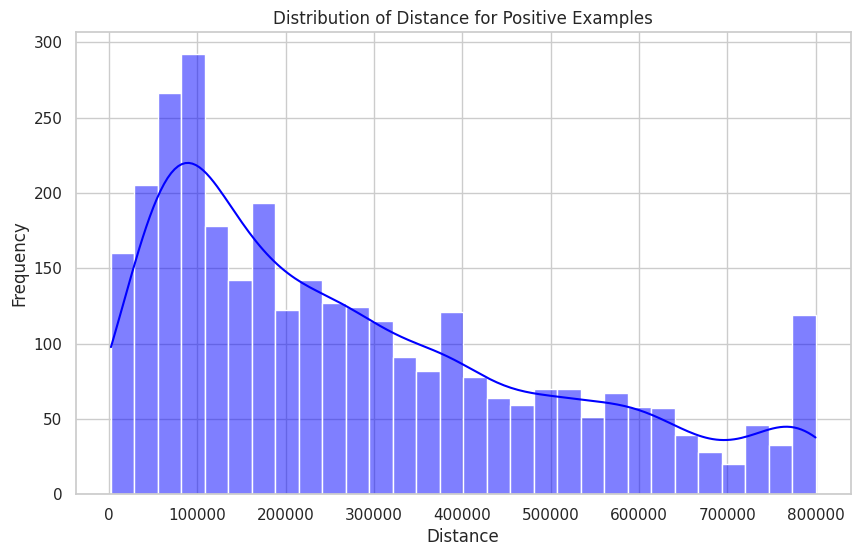

3219
2615


In [18]:

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# 加载数据
positive_examples = pd.read_csv('/home/tjzhang03/zxj/deal_data/data_process/EG2EP/All-Pairs.Natural-Ratio/K562.HiC-Benchmark.v3_ep_distanceisWindows.txt', sep='\t')
positive_examples = positive_examples[(positive_examples['distance'] <= 800000)]

# 设置图形的样式
sns.set(style="whitegrid")

# 创建一个直方图
plt.figure(figsize=(10, 6))  # 可以调整图形的大小
sns.histplot(positive_examples['distance'], kde=True, color='blue', bins=30)  # KDE为True表示显示核密度估计
plt.title('Distribution of Distance for Positive Examples')
plt.xlabel('Distance')
plt.ylabel('Frequency')

# 显示图形
plt.show()

print(positive_examples.shape[0])
pos_samples_df = positive_examples[(positive_examples['distance'] >= 42000) & (positive_examples['distance'] <= 600000)]
# pos_samples_df = positive_examples[(positive_examples['distance'] >= 500000) ]
print(pos_samples_df.shape[0])


In [10]:
'''统计距离'''
import pandas as pd

# 加载数据
positive_examples = pd.read_csv('/home/tjzhang03/zxj/deal_data/data_process/EG2EP/All-Pairs.Natural-Ratio/IMR90.HiC-Benchmark.v3_ep_distanceisWindows.txt', sep='\t')

# 设置 bin 的大小和范围
bin_size = 2000
max_distance = int(positive_examples['distance'].max()) + bin_size  # 确保包含最大值，且强制为整数

# 生成 bins
bins = range(0, max_distance, bin_size)

# 划分 bins
distance_bins = pd.cut(positive_examples['distance'], bins=bins, right=False)

# 计算每个 bin 的样本数
bin_counts = distance_bins.value_counts().sort_index()

# 计算累积样本数
cumulative_counts = bin_counts.cumsum()

# 找到从 42000 开始累积样本数达到总样本的 80% 的最小 bin
total_samples = positive_examples.shape[0]
target_count = 0.8 * total_samples
cumulative_counts_from_42000 = cumulative_counts[cumulative_counts.index >= pd.Interval(42000, 42000+bin_size, closed='left')]

# 找到第一个使得累积样本数量从 42000 开始达到目标的 bin
k_bin = cumulative_counts_from_42000[cumulative_counts_from_42000 >= target_count].index[0]

# 打印结果
print(f"Bin where cumulative count reaches at least 80% of total samples starting from 42000: {k_bin}")
print(f"This corresponds to a distance from 42000 up to {k_bin.right}")


Bin where cumulative count reaches at least 80% of total samples starting from 42000: [328000, 330000)
This corresponds to a distance from 42000 up to 330000


In [5]:
'''筛选TSS'''
# 加载 GTF 文件
import pandas as pd
import re
from misc_utils import hg19_chromsize

def compute_promoter_region(tss, strand, chr_size):
    if strand == '+':
        start = max(1, tss - 1500)
        end = min(tss + 500, chr_size)
    else:
        start = max(1, tss - 500)
        end = min(tss + 1500, chr_size)
    return start, end

def standardize_gene_id(gene_id):
    # 正则表达式去除版本号和其他后缀
    match = re.match(r"(ENSG\d+)", gene_id)
    if match:
        return match.group(1)
    return None
def standardize_transcript_id(transcript_id):
    # 使用正则表达式去除版本号和其他后缀
    match = re.match(r"(ENST\d+)", transcript_id)
    if match:
        return match.group(1)
    return None

# 加载 GTF 文件
gtf_path = '/home/tjzhang03/zxj/deal_data/genomic_data/gencode.v43lift37.annotation.gtf'
gtf_data = pd.read_csv(gtf_path, comment='#', sep='\t', header=None, names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])

# 筛选出转录本
transcripts = gtf_data[gtf_data['feature'] == 'transcript']

# 解析属性字段
def parse_attributes(attribute_str):
    attributes = {}
    for attr in attribute_str.split(';'):
        if attr.strip():
            key_value = attr.strip().split(' ')
            if len(key_value) == 2:
                key, value = key_value
                attributes[key.strip()] = value.strip('"')
    return attributes

transcripts['attributes'] = transcripts['attribute'].apply(parse_attributes)
transcripts = transcripts[(transcripts['attributes'].apply(lambda x: x.get('transcript_type') in ['protein_coding', 'lincRNA', 'antisense_RNA'])) &
                          (transcripts['attributes'].apply(lambda x: int(x.get('level', 3)) <= 2))]

# 提取 TSS 并计算启动子区域
def compute_promoter(tss, strand):
    return (max(1, tss - 1500), tss + 500) if strand == '+' else (tss - 500, max(1, tss + 1500))

transcripts['TSS'] = transcripts.apply(lambda x: x['start'] if x['strand'] == '+' else x['end'], axis=1)
transcripts['chr_size'] = transcripts['chr'].map(hg19_chromsize)
transcripts[['promoter_start', 'promoter_end']] = transcripts.apply(lambda x: compute_promoter_region(x['TSS'], x['strand'], x['chr_size']), axis=1, result_type='expand')

# # 提取需要的信息
# transcripts['Gene_ID'] = transcripts['attributes'].apply(lambda x: x.get('gene_id'))
# transcripts['transcript_id'] = transcripts['attributes'].apply(lambda x: x.get('transcript_id'))
# 标准化 gene_id 和 transcript_id
transcripts['Gene_ID'] = transcripts['attributes'].apply(lambda x: standardize_gene_id(x.get('gene_id')))
transcripts['tss_ID'] = transcripts['attributes'].apply(lambda x: standardize_transcript_id(x.get('transcript_id')))


# 选择需要的列
final_transcripts = transcripts[['chr', 'promoter_start', 'promoter_end', 'strand', 'TSS', 'Gene_ID', 'tss_ID']]

# 显示结果
print(final_transcripts.head())


/tmp/ipykernel_58196/1841151015.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts['attributes'] = transcripts['attribute'].apply(parse_attributes)


      chr  promoter_start  promoter_end strand     TSS          Gene_ID  \
49   chr1           63919         65919      +   65419  ENSG00000186092   
144  chr1          233984        235984      -  234484  ENSG00000228463   
147  chr1          238058        240058      -  238558  ENSG00000228463   
151  chr1          266753        268753      -  267253  ENSG00000228463   
156  chr1          258621        260621      -  259121  ENSG00000228463   

              tss_ID  
49   ENST00000641515  
144  ENST00000442116  
147  ENST00000448958  
151  ENST00000424587  
156  ENST00000335577  


In [6]:
print(final_transcripts.shape)

(85181, 7)


In [23]:
'''创造阴性样本'''
import numpy as np

# 加载数据
positive_examples = pd.read_csv('/home/tjzhang03/zxj/deal_data/data_process/EG2EP/All-Pairs.Natural-Ratio/NHEK.HiC-Benchmark.v3_ep_distanceisWindows.txt', sep='\t')
positive_examples['Gene_ID'] = positive_examples['Gene_ID'].apply(standardize_gene_id)
positive_examples['tss_ID'] = positive_examples['tss_ID'].apply(standardize_transcript_id)
# 筛选出距离范围内的样本
pos_samples_df = positive_examples[(positive_examples['distance'] >= 42000) & (positive_examples['distance'] <= 500000)]
pos_samples_df = pos_samples_df[['chr', 'enhancer_start', 'enhancer_end', 'promoter_start', 'promoter_end', 'distance', 'label', 'strand', 'ccRE_ID', 'Gene_ID', 'tss_ID', 'enhancer_midpoint']]
# 预计算每个增强子的正样本数量
sample_counts = pos_samples_df['ccRE_ID'].value_counts()

# 获取增强子信息，避免后续重复的drop_duplicates操作
positive_enhancers = pos_samples_df.drop_duplicates()

# 使用set存储Gene_ID，用于快速查找和检查
positive_genes = set(positive_enhancers['Gene_ID'])

def generate_negative_samples(enhancer_row, transcripts_df, positive_genes, sample_counts):
    # 筛选条件
    mask = (
        (transcripts_df['chr'] == enhancer_row['chr']) &
        (~transcripts_df['Gene_ID'].isin(positive_genes)) &
        (42000 <= np.abs(transcripts_df['TSS'] - enhancer_row['enhancer_midpoint'])) &
        (np.abs(transcripts_df['TSS'] - enhancer_row['enhancer_midpoint']) <= 500000)
    )
    valid_transcripts = transcripts_df[mask]
    num_pos_samples = sample_counts.get(enhancer_row['ccRE_ID'], 0)

    # 检查可用的负样本数量并调整请求的样本数量
    num_samples_to_return = min(len(valid_transcripts), num_pos_samples)
    if num_samples_to_return < num_pos_samples:
        print(f"Not enough negative samples for CCRE_ID {enhancer_row['ccRE_ID']}. Expected {num_pos_samples}, got {num_samples_to_return}.")
    
    # 如果有足够的负样本候选，随机选择与正样本数量相同的负样本
    if len(valid_transcripts) > 0:
        samples = valid_transcripts.sample(n=num_samples_to_return)
        samples['enhancer_start'] = enhancer_row['enhancer_start']
        samples['enhancer_end'] = enhancer_row['enhancer_end']
        samples['label'] = 0  # 设置负样本标签为0
        samples['distance'] = np.abs(samples['TSS'] - enhancer_row['enhancer_midpoint'])
        samples['ccRE_ID'] = enhancer_row['ccRE_ID']
        return samples[['chr', 'enhancer_start', 'enhancer_end', 'promoter_start', 'promoter_end', 'distance', 'label', 'strand', 'ccRE_ID', 'Gene_ID', 'tss_ID']]
    else:
        return pd.DataFrame()
        
# 应用筛选函数
generated_samples = set()
negative_samples = pd.DataFrame()  #避免对同一 CCRE_ID 多次生成负样本
for index, enhancer in positive_enhancers.iterrows():
    if enhancer['ccRE_ID'] not in generated_samples:
        neg_samples = generate_negative_samples(enhancer, final_transcripts, positive_genes, sample_counts)
        negative_samples = pd.concat([negative_samples, neg_samples], ignore_index=True)
        generated_samples.add(enhancer['ccRE_ID'])

# negative_samples = pd.DataFrame()
# for index, enhancer in positive_enhancers.iterrows():
#     neg_samples = generate_negative_samples(enhancer, final_transcripts, positive_genes)
#     negative_samples = pd.concat([negative_samples, neg_samples], ignore_index=True)
print(f"Number of Positive Samples: {pos_samples_df.shape[0]}")
print(f"Number of Negative Samples: {negative_samples.shape[0]}")
# 合并正负样本并按照ccRE_ID进行分组，确保每组内正样本紧跟其负样本
all_samples = pd.concat([pos_samples_df, negative_samples], ignore_index=True)
all_samples_sorted = all_samples.sort_values(by=['ccRE_ID', 'label'], ascending=[True, False])

# 保存DataFrame到CSV
all_samples_sorted = all_samples_sorted[['chr', 'enhancer_start', 'enhancer_end', 'promoter_start', 'promoter_end', 'distance', 'label', 'strand', 'ccRE_ID', 'Gene_ID', 'tss_ID']]
output_file_path = '/home/tjzhang03/zxj/deal_data/data_process/create_data/NHEK.HiC-Benchmark.v3_ep_distanceisWindows.txt'
all_samples_sorted.to_csv(output_file_path, index=False, sep='\t')


Not enough negative samples for CCRE_ID EH37E0651270. Expected 3, got 1.
Not enough negative samples for CCRE_ID EH37E0847729. Expected 3, got 2.
Not enough negative samples for CCRE_ID EH37E0978080. Expected 1, got 0.
Not enough negative samples for CCRE_ID EH37E0704686. Expected 1, got 0.
Not enough negative samples for CCRE_ID EH37E1038604. Expected 2, got 0.
Not enough negative samples for CCRE_ID EH37E1038607. Expected 2, got 0.
Not enough negative samples for CCRE_ID EH37E1038602. Expected 2, got 0.
Not enough negative samples for CCRE_ID EH37E1038603. Expected 2, got 0.
Not enough negative samples for CCRE_ID EH37E0704852. Expected 1, got 0.
Not enough negative samples for CCRE_ID EH37E0704859. Expected 1, got 0.
Not enough negative samples for CCRE_ID EH37E1038606. Expected 2, got 0.
Not enough negative samples for CCRE_ID EH37E0978938. Expected 2, got 0.
Not enough negative samples for CCRE_ID EH37E0692002. Expected 2, got 1.
Not enough negative samples for CCRE_ID EH37E097888

In [25]:
# print(negative_samples.head)
# print(sample_counts)
# 定义文件路径
output_file_path = '/home/tjzhang03/zxj/deal_data/data_process/create_data/NHEK.HiC-Benchmark.v3_ep_distanceisWindows.txt'
all_samples_sorted = all_samples_sorted[['chr', 'enhancer_start', 'enhancer_end', 'promoter_start', 'promoter_end', 'distance', 'label', 'strand', 'ccRE_ID', 'Gene_ID', 'tss_ID']]

# 保存DataFrame到CSV
all_samples_sorted.to_csv(output_file_path, index=False, sep='\t')

In [8]:
import pandas as pd

# 加载数据
positive_examples = pd.read_csv('/home/tjzhang03/zxj/deal_data/data_process/EG2EP/All-Pairs.Natural-Ratio/NHEK.HiC-Benchmark.v3_ep_distanceisWindows.txt', sep='\t')

# 只考虑大于 42000 的距离
distances = positive_examples[positive_examples['distance'] > 42000]['distance']

# 设置 bin 的大小和范围
bin_size = 2000
max_distance = distances.max() + bin_size  # 确保包含最大值
bins = range(42000, max_distance, bin_size)

# 划分 bins
distance_bins = pd.cut(distances, bins=bins, right=False)

# 计算每个 bin 的样本数
bin_counts = distance_bins.value_counts().sort_index()

# 计算累积样本数
cumulative_counts = bin_counts.cumsum()

# 找到累积样本数达到总样本的 80% 的最小 bin
total_samples = positive_examples.shape[0]
target_count = 0.8 * total_samples
k_bin = cumulative_counts[cumulative_counts >= target_count].index[0]

# 打印结果
print(f"Bin where cumulative count reaches at least 80% of total samples: {k_bin}")
print(f"This corresponds to a distance from 42000 up to {k_bin.right}")


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [8]:
import numpy as np

# 加载npz文件
data = np.load('/home/tjzhang03/zxj/DeepTACT-master/demo/P-E/enhancer_DNase.npz')

# 列出文件中所有的数组
print(list(data.keys()))

# 打印每个数组的名称和形状
for key in data:
    print(f"Array name: {key}")
    print(f"Shape of the array: {data[key].shape}")

# 关闭文件
data.close()



['expr']
Array name: expr
Shape of the array: (100, 6000)
